In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import xarray as xr
import rioxarray
import rasterio
import glob
import os
from odc.geo.xr import xr_reproject
from shapely.geometry import shape
from rasterio.enums import Resampling
from rasterio import shutil as rio_shutil
from rasterio.vrt import WarpedVRT

/home/teemo/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
!pip show geopandas

Name: geopandas
Version: 1.0.1
Summary: Geographic pandas extensions
Home-page: 
Author: 
Author-email: Kelsey Jordahl <kjordahl@alum.mit.edu>
License: BSD 3-Clause
Location: /home/teemo/anaconda3/lib/python3.11/site-packages
Requires: numpy, packaging, pandas, pyogrio, pyproj, shapely
Required-by: 


# Creating the data for the boundaries - *federal_states* table

the data comes from NUTS5000 
- federal_states == Bundestaat

## Load the data

In [3]:
# file paths
f_states_fp = "../borders/NUTS5000_N1.shp"

### Cleaning df_f_states

In [4]:
# look at the shapefile
df_f_states = gpd.read_file(f_states_fp)
df_f_states.head()

,OBJID,BEGINN,GF,NUTS_LEVEL,NUTS_CODE,NUTS_NAME,geometry
0,DEBKGNU5000000C8,2021-10-04,9,1,DE1,Baden-Württemberg,"MULTIPOLYGON (((477730.872 5284627.86, 478787...."
1,DEBKGNU5000000C9,2021-10-04,9,1,DE2,Bayern,"POLYGON ((792217.27 5346780.081, 787582.436 53..."
2,DEBKGNU5000000CA,2021-10-04,9,1,DE3,Berlin,"POLYGON ((791413.725 5842844.467, 790893.811 5..."
3,DEBKGNU5000000CB,2021-10-04,9,1,DE4,Brandenburg,"POLYGON ((819216.472 5702543.614, 817838.547 5..."
4,DEBKGNU5000000CC,2021-10-04,9,1,DE5,Bremen,"MULTIPOLYGON (((471011.958 5933445.037, 468446..."


In [5]:
# remove columns from df_states except for code, name and geometry:
df_f_states = df_f_states.drop(columns = ["OBJID", "BEGINN", "GF", "NUTS_LEVEL"])

In [6]:
states_id = df_f_states["NUTS_CODE"]
states_id.head()

0    DE1
1    DE2
2    DE3
3    DE4
4    DE5
Name: NUTS_CODE, dtype: object

In [7]:
# convert to list
states_id = states_id.to_list()

## Change column names

In [22]:
# change column names:
df_f_states = df_f_states.rename(columns= {"NUTS_CODE" : "state_id", "NUTS_NAME" : "state_name"})

In [23]:
df_f_states.head()

,state_id,state_name,geometry
0,DE1,Baden-Württemberg,"MULTIPOLYGON (((477730.872 5284627.86, 478787...."
1,DE2,Bayern,"POLYGON ((792217.27 5346780.081, 787582.436 53..."
2,DE3,Berlin,"POLYGON ((791413.725 5842844.467, 790893.811 5..."
3,DE4,Brandenburg,"POLYGON ((819216.472 5702543.614, 817838.547 5..."
4,DE5,Bremen,"MULTIPOLYGON (((471011.958 5933445.037, 468446..."


## Change column position

<Axes: >

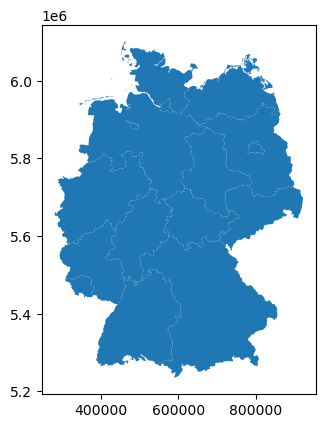

In [28]:
df_f_states.plot()

## Save the files

In [31]:
# df_forwind.to_file("../wind/forwind_clean.shp")
df_f_states.to_file("../borders/clean_borders/federal_states.shp")

# delete structures to save memory
del df_f_states

/tmp/ipykernel_894138/1956223440.py:3: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  df_govt_d.to_file("../borders/clean_borders/govt_districts.shp")
/home/teemo/anaconda3/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'govt_district_id' to 'govt_distr'
  ogr_write(
/home/teemo/anaconda3/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'govt_district_name' to 'govt_dis_1'
  ogr_write(
/tmp/ipykernel_894138/1956223440.py:4: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  df_districts.to_file("../borders/clean_borders/districts.shp")
/home/teemo/anaconda3/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'district_id' to 'district_i'
  ogr_write(
/home/teemo/anaconda3/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: No

# Reprojecting Thünen Dominant_Tree_Classes.tiff file

In [ ]:
trees_fp = "../trees/Dominant_Species_Class.tif"
out_fp = "../trees/reprojected_trees1"

In [ ]:
target_crs = "EPSG:25832"

vrt_options = {
    "resampling": Resampling.cubic,
    "crs": target_crs,
    "dtype": "uint8",
    "compress": "JPEG",  
    "photometric": "YCBCR"
}

with rasterio.open(trees_fp) as src:

    print("step 1")
    with WarpedVRT(src, **vrt_options) as vrt:

        # At this point 'vrt' is a full dataset with dimensions,
        # CRS, and spatial extent matching 'vrt_options'.

        # Read all data into memory.
        data = vrt.read()

        print("step 2")

        # Process the dataset in chunks.  Likely not very efficient.
        for _, window in vrt.block_windows():
            data = vrt.read(window=window)
        # Dump the aligned data into a new file.  A VRT representing
        # this transformation can also be produced by switching
        # to the VRT driver.
        #directory, name = os.path.split(path)
        #outfile = os.path.join(directory, 'aligned-{}'.format(name))
        print("step 3")
        rio_shutil.copy(vrt, out_fp, driver='GTiff')


In [ ]:
del data
del vrt

# Creating the data for the *events* table - shapefile data

using the data from:
- EFFIS fire events
- forwind storm damage


1. load the data 
2. clean the data - convert rasters to shp
3. create event_id, cause, ref_id, year, month, day columns

## Loading the data from each file

In [32]:
# file paths
effis_fp = "../fire/burnt_area_de_EFFIS.shp"
forwind_fp = "../wind/FORWIND_v2.shp"

In [33]:
# look at the shapefiles
# fire disturbances
df_effis = gpd.read_file(effis_fp)
df_effis.head()

,id,FIREDATE,LASTUPDATE,COUNTRY,PROVINCE,COMMUNE,AREA_HA,BROADLEA,CONIFER,MIXED,SCLEROPH,TRANSIT,OTHERNATLC,AGRIAREAS,ARTIFSURF,OTHERLC,PERCNA2K,CLASS,Year,geometry
0,176727,2001-07-27 00:00:00,2001-08-03 00:00:00,DE,Haßberge,"Königsberg i.Bay., St",31,53.333333333155565,0,0,0,0,0,46.66666666651111,0,0,0,FireSeason,2001,"POLYGON ((10.50244 50.0708, 10.50244 50.0752, ..."
1,177477,2001-08-15 00:00:00,2001-08-15 00:00:00,DE,Minden-Lübbecke,"Petershagen, Stadt",29,0,30.769230769112426,0,0,0,0,69.23076923050296,0,0,0,FireSeason,2001,"POLYGON ((8.9292 52.35596, 8.93799 52.35596, 8..."
2,178047,2001-08-31 00:00:00,2001-08-31 00:00:00,DE,Neckar-Odenwald-Kreis,Limbach,16,0,73.33333333284445,26.666666666488887,0,0,0,0,0,0,0,FireSeason,2001,"POLYGON ((9.12695 49.48633, 9.13135 49.48633, ..."
3,169485,2003-02-19 00:00:00,2003-03-05 00:00:00,DE,Schwäbisch Hall,Fichtenberg,1431,0,62.46498599439339,6.022408963585012,0,0,0,23.38935574229528,8.123249299719319,0,0.47173602911254975,FireSeason,2003,"POLYGON ((9.71582 48.96338, 9.71582 48.95898, ..."
4,169499,2003-02-22 00:00:00,2003-02-22 00:00:00,DE,Rems-Murr-Kreis,"Murrhardt, Stadt",31,0,46.66666666651111,49.99999999983334,0,0,0,3.333333333322223,0,0,0,FireSeason,2003,"POLYGON ((9.65869 48.96777, 9.66748 48.96777, ..."


<Axes: >

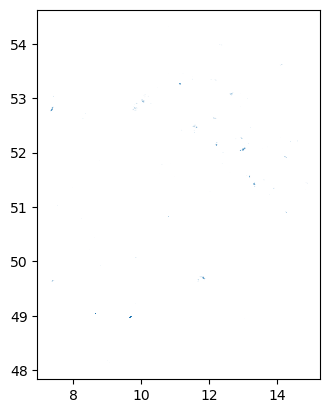

In [34]:
#print(df_effis.count())
df_effis.plot()

In [35]:
df_effis["COUNTRY"].unique()

array(['DE'], dtype=object)

In [36]:
# wind disturbance
df_forwind = gpd.read_file(forwind_fp)
df_forwind.head()

,Id_poly,EventDate,StormName,EventType,Country,Area,Perimeter,Damage_deg,Methods,Dataprovid,Source,geometry
0,1,2000-07-25,unknown,Tornado,RU,18.301443,4202.68751206554,-999.0,Satellite data classification,"Department of Cartography and Geoinformatics, ...",https://www.sciencedirect.com/science/article/...,"POLYGON ((32.46924 56.49643, 32.46874 56.49643..."
1,2,2000-07-25,unknown,Tornado,RU,9.794659,2703.62054229026,-999.0,Satellite data classification,"Department of Cartography and Geoinformatics, ...",https://www.sciencedirect.com/science/article/...,"POLYGON ((32.58049 56.41893, 32.57899 56.41905..."
2,3,2000-07-25,unknown,Tornado,RU,8.665567,2364.82244169863,-999.0,Satellite data classification,"Department of Cartography and Geoinformatics, ...",https://www.sciencedirect.com/science/article/...,"POLYGON ((32.48349 56.48893, 32.48199 56.48893..."
3,4,2000-07-25,unknown,Tornado,RU,5.967622,1372.19812350868,-999.0,Satellite data classification,"Department of Cartography and Geoinformatics, ...",https://www.sciencedirect.com/science/article/...,"POLYGON ((32.50702 56.4788, 32.50837 56.47853,..."
4,5,2000-07-25,unknown,Tornado,RU,4.557400,2012.7888046014,-999.0,Satellite data classification,"Department of Cartography and Geoinformatics, ...",https://www.sciencedirect.com/science/article/...,"POLYGON ((32.51199 56.47418, 32.51349 56.47443..."


<Axes: >

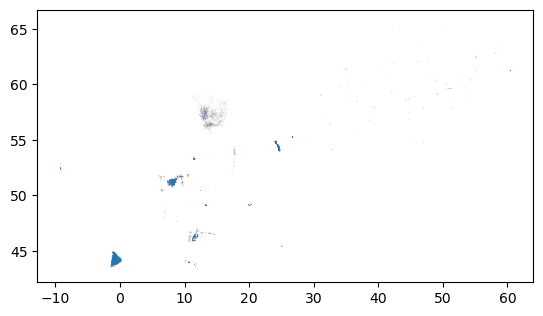

In [37]:
df_forwind.plot()

In [38]:
df_forwind.count()

Id_poly       89743
EventDate     89743
StormName     89743
EventType     89743
Country       89743
Area          89743
Perimeter     89743
Damage_deg    89743
Methods       89743
Dataprovid    89743
Source        89743
geometry      89743
dtype: int64

In [39]:
# how many countries are present?
df_forwind["Country"].unique()

array(['RU', 'SK', 'SE', 'RO', 'CZ', 'DE', 'FR', 'LT', 'PL', 'IR', 'IT',
       'CH', 'AU'], dtype=object)

## Clean the data
- create event_id, cause, ref_id, year, month, day columns

### EFFIS fire data

In [40]:
old_cols = df_effis.columns.to_list()
old_cols

['id',
 'FIREDATE',
 'LASTUPDATE',
 'COUNTRY',
 'PROVINCE',
 'COMMUNE',
 'AREA_HA',
 'BROADLEA',
 'CONIFER',
 'MIXED',
 'SCLEROPH',
 'TRANSIT',
 'OTHERNATLC',
 'AGRIAREAS',
 'ARTIFSURF',
 'OTHERLC',
 'PERCNA2K',
 'CLASS',
 'Year',
 'geometry']

In [41]:
# simple function to choose which columns to drop
def remove_columns(old_columns, kept_columns):
    for x in kept_columns:
        if x in old_columns:
            old_columns.remove(x)
    return old_columns

In [42]:
old_cols = remove_columns(old_cols, ["id", "FIREDATE", "COUNTRY", "geometry"])
old_cols

['LASTUPDATE',
 'PROVINCE',
 'COMMUNE',
 'AREA_HA',
 'BROADLEA',
 'CONIFER',
 'MIXED',
 'SCLEROPH',
 'TRANSIT',
 'OTHERNATLC',
 'AGRIAREAS',
 'ARTIFSURF',
 'OTHERLC',
 'PERCNA2K',
 'CLASS',
 'Year']

In [43]:
# drop the unneeded columns
df_effis = df_effis.drop(columns= old_cols)
df_effis.head()

,id,FIREDATE,COUNTRY,geometry
0,176727,2001-07-27 00:00:00,DE,"POLYGON ((10.50244 50.0708, 10.50244 50.0752, ..."
1,177477,2001-08-15 00:00:00,DE,"POLYGON ((8.9292 52.35596, 8.93799 52.35596, 8..."
2,178047,2001-08-31 00:00:00,DE,"POLYGON ((9.12695 49.48633, 9.13135 49.48633, ..."
3,169485,2003-02-19 00:00:00,DE,"POLYGON ((9.71582 48.96338, 9.71582 48.95898, ..."
4,169499,2003-02-22 00:00:00,DE,"POLYGON ((9.65869 48.96777, 9.66748 48.96777, ..."


#### Split the dates 

In [44]:
df_effis["year"] = df_effis["FIREDATE"].str[:4].astype(int)
df_effis["month"] = df_effis["FIREDATE"].str[5:7].astype(int)
df_effis["day"] = df_effis["FIREDATE"].str[8:10].astype(int)
df_effis.head()

,id,FIREDATE,COUNTRY,geometry,year,month,day
0,176727,2001-07-27 00:00:00,DE,"POLYGON ((10.50244 50.0708, 10.50244 50.0752, ...",2001,7,27
1,177477,2001-08-15 00:00:00,DE,"POLYGON ((8.9292 52.35596, 8.93799 52.35596, 8...",2001,8,15
2,178047,2001-08-31 00:00:00,DE,"POLYGON ((9.12695 49.48633, 9.13135 49.48633, ...",2001,8,31
3,169485,2003-02-19 00:00:00,DE,"POLYGON ((9.71582 48.96338, 9.71582 48.95898, ...",2003,2,19
4,169499,2003-02-22 00:00:00,DE,"POLYGON ((9.65869 48.96777, 9.66748 48.96777, ...",2003,2,22


In [45]:
# drop data after 2021
print(f"before: {df_effis['year'].unique()}")
df_effis = df_effis[df_effis["year"] < 2022]
print(f"after: {df_effis['year'].unique()}")

before: [2001 2003 2004 2005 2013 2015 2016 2017 2018 2019 2020 2021 2022 2023
 2024]
after: [2001 2003 2004 2005 2013 2015 2016 2017 2018 2019 2020 2021]


In [46]:
df_effis = df_effis.drop(columns= ["FIREDATE", "COUNTRY"])
df_effis.head()

,id,geometry,year,month,day
0,176727,"POLYGON ((10.50244 50.0708, 10.50244 50.0752, ...",2001,7,27
1,177477,"POLYGON ((8.9292 52.35596, 8.93799 52.35596, 8...",2001,8,15
2,178047,"POLYGON ((9.12695 49.48633, 9.13135 49.48633, ...",2001,8,31
3,169485,"POLYGON ((9.71582 48.96338, 9.71582 48.95898, ...",2003,2,19
4,169499,"POLYGON ((9.65869 48.96777, 9.66748 48.96777, ...",2003,2,22


#### Create ref_id column

In [47]:
df_effis["ref_id"] = "r7"
df_effis.head()

,id,geometry,year,month,day,ref_id
0,176727,"POLYGON ((10.50244 50.0708, 10.50244 50.0752, ...",2001,7,27,r7
1,177477,"POLYGON ((8.9292 52.35596, 8.93799 52.35596, 8...",2001,8,15,r7
2,178047,"POLYGON ((9.12695 49.48633, 9.13135 49.48633, ...",2001,8,31,r7
3,169485,"POLYGON ((9.71582 48.96338, 9.71582 48.95898, ...",2003,2,19,r7
4,169499,"POLYGON ((9.65869 48.96777, 9.66748 48.96777, ...",2003,2,22,r7


#### Add *cause* column

In [48]:
# remove any multi-index issues
df_effis = df_effis.reset_index(drop=True)  
df_effis["cause"] = "fire"
df_effis.head()

,id,geometry,year,month,day,ref_id,cause
0,176727,"POLYGON ((10.50244 50.0708, 10.50244 50.0752, ...",2001,7,27,r7,fire
1,177477,"POLYGON ((8.9292 52.35596, 8.93799 52.35596, 8...",2001,8,15,r7,fire
2,178047,"POLYGON ((9.12695 49.48633, 9.13135 49.48633, ...",2001,8,31,r7,fire
3,169485,"POLYGON ((9.71582 48.96338, 9.71582 48.95898, ...",2003,2,19,r7,fire
4,169499,"POLYGON ((9.65869 48.96777, 9.66748 48.96777, ...",2003,2,22,r7,fire


#### Order the columns:

In [49]:
df_effis = df_effis[["id", "cause", "year", "month", "day", "ref_id", "geometry"]]
df_effis.head()

,id,cause,year,month,day,ref_id,geometry
0,176727,fire,2001,7,27,r7,"POLYGON ((10.50244 50.0708, 10.50244 50.0752, ..."
1,177477,fire,2001,8,15,r7,"POLYGON ((8.9292 52.35596, 8.93799 52.35596, 8..."
2,178047,fire,2001,8,31,r7,"POLYGON ((9.12695 49.48633, 9.13135 49.48633, ..."
3,169485,fire,2003,2,19,r7,"POLYGON ((9.71582 48.96338, 9.71582 48.95898, ..."
4,169499,fire,2003,2,22,r7,"POLYGON ((9.65869 48.96777, 9.66748 48.96777, ..."


#### Rename id column

In [50]:
df_effis = df_effis.rename(columns= {"id": "event_id"})
df_effis.head()

,event_id,cause,year,month,day,ref_id,geometry
0,176727,fire,2001,7,27,r7,"POLYGON ((10.50244 50.0708, 10.50244 50.0752, ..."
1,177477,fire,2001,8,15,r7,"POLYGON ((8.9292 52.35596, 8.93799 52.35596, 8..."
2,178047,fire,2001,8,31,r7,"POLYGON ((9.12695 49.48633, 9.13135 49.48633, ..."
3,169485,fire,2003,2,19,r7,"POLYGON ((9.71582 48.96338, 9.71582 48.95898, ..."
4,169499,fire,2003,2,22,r7,"POLYGON ((9.65869 48.96777, 9.66748 48.96777, ..."


### Forwind data

In [51]:
old_columns = df_forwind.columns.to_list()
old_columns

['Id_poly',
 'EventDate',
 'StormName',
 'EventType',
 'Country',
 'Area',
 'Perimeter',
 'Damage_deg',
 'Methods',
 'Dataprovid',
 'Source',
 'geometry']

In [52]:
keep = ["Id_poly", "EventDate", "Country", "geometry"]
columns_to_remove = remove_columns(old_columns, keep)
columns_to_remove

['StormName',
 'EventType',
 'Area',
 'Perimeter',
 'Damage_deg',
 'Methods',
 'Dataprovid',
 'Source']

In [53]:
df_forwind = df_forwind.drop(columns= columns_to_remove)
df_forwind

,Id_poly,EventDate,Country,geometry
0,1,2000-07-25,RU,"POLYGON ((32.46924 56.49643, 32.46874 56.49643..."
1,2,2000-07-25,RU,"POLYGON ((32.58049 56.41893, 32.57899 56.41905..."
2,3,2000-07-25,RU,"POLYGON ((32.48349 56.48893, 32.48199 56.48893..."
3,4,2000-07-25,RU,"POLYGON ((32.50702 56.4788, 32.50837 56.47853,..."
4,5,2000-07-25,RU,"POLYGON ((32.51199 56.47418, 32.51349 56.47443..."
...,...,...,...,...
89738,89739,2018-10-28,IT,"POLYGON ((11.37908 46.2654, 11.37882 46.26531,..."
89739,89740,2018-10-28,IT,"POLYGON ((11.37381 46.26412, 11.37357 46.26416..."
89740,89741,2018-10-28,IT,"POLYGON ((11.37946 46.2648, 11.37985 46.26497,..."
89741,89742,2018-10-28,IT,"POLYGON ((11.37998 46.26466, 11.37983 46.26434..."


#### Select features in DE only

In [54]:
df_forwind = df_forwind[df_forwind["Country"] == "DE"]
df_forwind.head()

,Id_poly,EventDate,Country,geometry
23009,23010,2007-01-07,DE,"POLYGON ((6.58108 50.38085, 6.58122 50.38081, ..."
23010,23011,2007-01-07,DE,"POLYGON ((6.37201 50.38119, 6.37226 50.38117, ..."
23011,23012,2007-01-07,DE,"POLYGON ((6.73572 50.37751, 6.73588 50.37748, ..."
23012,23013,2007-01-07,DE,"POLYGON ((6.35335 50.37764, 6.35347 50.37755, ..."
23013,23014,2007-01-07,DE,"POLYGON ((6.55789 50.37464, 6.55794 50.37457, ..."


In [55]:
df_forwind["Country"].unique()

array(['DE'], dtype=object)

In [56]:
df_forwind.count()

Id_poly      18909
EventDate    18909
Country      18909
geometry     18909
dtype: int64

#### Split the dates 

In [57]:
df_forwind["year"] = df_forwind["EventDate"].str[:4].astype(int)
df_forwind["month"] = df_forwind["EventDate"].str[5:7].astype(int)
df_forwind["day"] = df_forwind["EventDate"].str[8:10].astype(int)
df_forwind.head()

/home/teemo/anaconda3/lib/python3.11/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/teemo/anaconda3/lib/python3.11/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/teemo/anaconda3/lib/python3.11/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

,Id_poly,EventDate,Country,geometry,year,month,day
23009,23010,2007-01-07,DE,"POLYGON ((6.58108 50.38085, 6.58122 50.38081, ...",2007,1,7
23010,23011,2007-01-07,DE,"POLYGON ((6.37201 50.38119, 6.37226 50.38117, ...",2007,1,7
23011,23012,2007-01-07,DE,"POLYGON ((6.73572 50.37751, 6.73588 50.37748, ...",2007,1,7
23012,23013,2007-01-07,DE,"POLYGON ((6.35335 50.37764, 6.35347 50.37755, ...",2007,1,7
23013,23014,2007-01-07,DE,"POLYGON ((6.55789 50.37464, 6.55794 50.37457, ...",2007,1,7


In [58]:
# drop data after 2021
print(f"before: {df_forwind['year'].unique()}")
df_forwind = df_forwind[df_forwind["year"] < 2022]
print(f"after: {df_forwind['year'].unique()}")

before: [2007 2017 2018]
after: [2007 2017 2018]


In [59]:
df_forwind = df_forwind.drop(columns= ["Country", "EventDate"])
df_forwind.head()

,Id_poly,geometry,year,month,day
23009,23010,"POLYGON ((6.58108 50.38085, 6.58122 50.38081, ...",2007,1,7
23010,23011,"POLYGON ((6.37201 50.38119, 6.37226 50.38117, ...",2007,1,7
23011,23012,"POLYGON ((6.73572 50.37751, 6.73588 50.37748, ...",2007,1,7
23012,23013,"POLYGON ((6.35335 50.37764, 6.35347 50.37755, ...",2007,1,7
23013,23014,"POLYGON ((6.55789 50.37464, 6.55794 50.37457, ...",2007,1,7


#### Add the ref_id column

In [60]:
# ref id for forwind date is r1
df_forwind["ref_id"] = "r1"
df_forwind.head()

,Id_poly,geometry,year,month,day,ref_id
23009,23010,"POLYGON ((6.58108 50.38085, 6.58122 50.38081, ...",2007,1,7,r1
23010,23011,"POLYGON ((6.37201 50.38119, 6.37226 50.38117, ...",2007,1,7,r1
23011,23012,"POLYGON ((6.73572 50.37751, 6.73588 50.37748, ...",2007,1,7,r1
23012,23013,"POLYGON ((6.35335 50.37764, 6.35347 50.37755, ...",2007,1,7,r1
23013,23014,"POLYGON ((6.55789 50.37464, 6.55794 50.37457, ...",2007,1,7,r1


#### Add the cause columnm

In [61]:
df_forwind = df_forwind.reset_index(drop=True)  
df_forwind["cause"] = "wind/bark beetle"
df_forwind.head()

,Id_poly,geometry,year,month,day,ref_id,cause
0,23010,"POLYGON ((6.58108 50.38085, 6.58122 50.38081, ...",2007,1,7,r1,wind/bark beetle
1,23011,"POLYGON ((6.37201 50.38119, 6.37226 50.38117, ...",2007,1,7,r1,wind/bark beetle
2,23012,"POLYGON ((6.73572 50.37751, 6.73588 50.37748, ...",2007,1,7,r1,wind/bark beetle
3,23013,"POLYGON ((6.35335 50.37764, 6.35347 50.37755, ...",2007,1,7,r1,wind/bark beetle
4,23014,"POLYGON ((6.55789 50.37464, 6.55794 50.37457, ...",2007,1,7,r1,wind/bark beetle


#### Order the columns:

In [62]:
df_forwind = df_forwind[["Id_poly", "cause", "year", "month", "day", "ref_id", "geometry"]]
df_forwind.head()

,Id_poly,cause,year,month,day,ref_id,geometry
0,23010,wind/bark beetle,2007,1,7,r1,"POLYGON ((6.58108 50.38085, 6.58122 50.38081, ..."
1,23011,wind/bark beetle,2007,1,7,r1,"POLYGON ((6.37201 50.38119, 6.37226 50.38117, ..."
2,23012,wind/bark beetle,2007,1,7,r1,"POLYGON ((6.73572 50.37751, 6.73588 50.37748, ..."
3,23013,wind/bark beetle,2007,1,7,r1,"POLYGON ((6.35335 50.37764, 6.35347 50.37755, ..."
4,23014,wind/bark beetle,2007,1,7,r1,"POLYGON ((6.55789 50.37464, 6.55794 50.37457, ..."


#### Rename Id_poly to event_id

In [63]:
df_forwind = df_forwind.rename(columns= {"Id_poly": "event_id"})
df_forwind.head()

,event_id,cause,year,month,day,ref_id,geometry
0,23010,wind/bark beetle,2007,1,7,r1,"POLYGON ((6.58108 50.38085, 6.58122 50.38081, ..."
1,23011,wind/bark beetle,2007,1,7,r1,"POLYGON ((6.37201 50.38119, 6.37226 50.38117, ..."
2,23012,wind/bark beetle,2007,1,7,r1,"POLYGON ((6.73572 50.37751, 6.73588 50.37748, ..."
3,23013,wind/bark beetle,2007,1,7,r1,"POLYGON ((6.35335 50.37764, 6.35347 50.37755, ..."
4,23014,wind/bark beetle,2007,1,7,r1,"POLYGON ((6.55789 50.37464, 6.55794 50.37457, ..."


## Reprojecting the shapefiles

In [64]:
# current crs
print(f"df_effis crs: {df_effis.crs}\n")
print(f"\ndf_forwind crs: {df_forwind.crs}")

df_effis crs: GEOGCS["GCS_WGS_84_CRS84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433],AXIS["Longitude",EAST],AXIS["Latitude",NORTH]]


df_forwind crs: EPSG:4326


In [65]:
# reproject to EPSG:25832 as it is the CRS of the NUTS50000 shapefiles
df_effis = df_effis.to_crs("EPSG:25832")
df_forwind = df_forwind.to_crs("EPSG:25832")

## Save as new shapefiles

In [66]:
df_effis.to_file("../fire/effis_clean.shp")
df_forwind.to_file("../wind/forwind_clean.shp")

# delete dataframes to save on ram
del df_effis
del df_forwind

# Creating data for the *events* table - rasters

- using the EU disturbance atlas files - disturbance_agent & last_disturbance

process the data:
1. Convert to shapefiles
2. Merge year and disturbance agent into one shapefile
3. Finalise the cause columnm
4. Finalse the year - month - day columns
5. Add ref_id column

## Reproject latest_disturbance + disturbance_agent

- First reproject to EPSG:25832 and then 
- clip the rasters to the federal states. 
- Hopefully the new sizes are compact enough for polygonisation to work

In [67]:
target_crs = "EPSG:25832"

### Disturbance agents

In [68]:
# read raster
disturbance_atlas_fp = "../atlas/disturbance_agent_germany.tif" 
disturbance_rast = rioxarray.open_rasterio(disturbance_atlas_fp) 
# reproject and save
reprojected_raster = xr_reproject(disturbance_rast, how=target_crs)
reprojected_raster.isel(band = 0).rio.to_raster("../atlas/reprojected_agents.tif")

# delete to save ram
del reprojected_raster

### latest disturbance

In [69]:
# read in raster
latest_fp = "../atlas/latest_disturbance_germany.tif"
latest_r = rioxarray.open_rasterio(latest_fp)
# reproject and save
reprojected_latest = xr_reproject(latest_r, how = target_crs)
reprojected_latest.isel(band = 0).rio.to_raster("../atlas/reprojected_latest.tif")

# delete to save ram
del reprojected_latest

## Clip rasters to boundaries

done in QGIS!
- click on raster layer
- go `raster` -> `extract` -> `clip raster by mask layer`
- input the paramters, run for each state and save to be used below

## Convert rasters into shapefiles
done in QGIS!
- click on raster layer
- go `raster` -> `conversion` -> `Polygonize (Raster to Vector)`
- run for each raster file created in the previous step

## Cleaning the new shapefiles

### Read in disturbance agents and latest disturbance shp's

In [70]:
disturbance_fp = "../atlas/poly_disturbances/"
latest_fp = "../atlas/poly_latest/"

In [17]:
# each federal states is a shapefile
# the format of each file name follows the abbrevaited form of the state as two chars; Brandenburg -> bb
# return a list with all the shapefiles, either from disturbance agents or latest disturbance 
def read_shps(fp):
    with os.scandir(fp) as entries:
        files = sorted([entry.name for entry in entries if entry.is_file() and entry.name.endswith('.shp')])
    
    fps = []
    
    for file in files:
        filepath = os.path.join(fp, file)
        gdf = gpd.read_file(filepath)
        fps.append([file[:2], gdf])
        print(f"Loaded: {file}")
    return fps

Loaded: bb_disturb1.shp
Loaded: be_disturb1.shp
Loaded: bw_disturb1.shp
Loaded: by_disturb1.shp
Loaded: hb_disturb1.shp
Loaded: he_disturb1.shp
Loaded: hh_disturb1.shp
Loaded: mv_disturb1.shp
Loaded: ni_disturb1.shp
Loaded: nw_disturb1.shp
Loaded: rp_disturb1.shp
Loaded: sh_disturb1.shp
Loaded: sl_disturb1.shp
Loaded: sn_disturb1.shp
Loaded: st_disturb1.shp
Loaded: th_disturb1.shp


<Axes: >

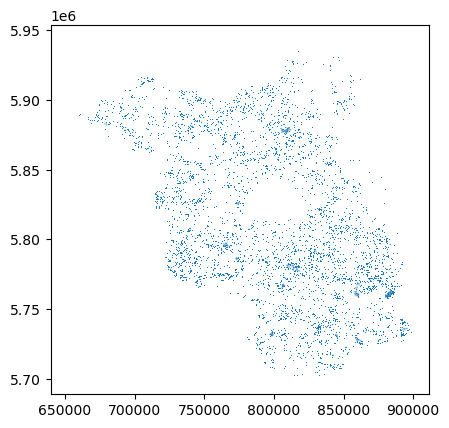

In [72]:
# lists with data for each state as a shapefile
disturbance_shps = read_shps(disturbance_fp)
# should plot the disturbance agent shp for brandenburg
disturbance_shps[0][1].plot()

Loaded: bb_latest1.shp
Loaded: be_latest1.shp
Loaded: bw_latest1.shp
Loaded: by_latest1.shp
Loaded: hb_latest1.shp
Loaded: he_latest1.shp
Loaded: hh_latest1.shp
Loaded: mv_latest1.shp
Loaded: ni_latest1.shp
Loaded: nw_latest1.shp
Loaded: rp_latest1.shp
Loaded: sh_latest1.shp
Loaded: sl_latest1.shp
Loaded: sn_latest1.shp
Loaded: st_latest1.shp
Loaded: th_latest1.shp


<Axes: >

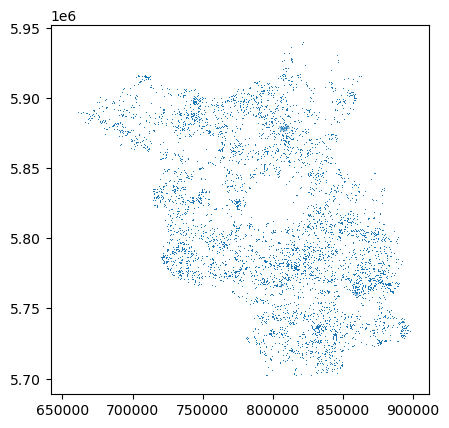

In [73]:
latest_shps = read_shps(latest_fp)
# should plot the latest disturbance year shp for brandenburg
latest_shps[0][1].plot()

### Perform right nearest spatial join and clean up the attributes  

In [74]:
def clean_shp(shp, idx):
    # drop empty rows - will likely result in data loss
    shp = shp.dropna()
    
    if "fid" in shp.columns.to_list():
        shp = shp.drop(columns= "fid")
        print("drop index_left column")
    
    # rename columns
    shp = shp.rename(columns= {"index_left" : "event_id", "DN_left" : "cause", "DN_right" : "year"})
    
    # add month, day and ref_id's
    shp["month"] = np.nan
    shp["day"] = np.nan 
    shp["ref_id"] = "r5" # a foreign key
    
    # reformat the float values into human readable names
    shp["cause"] = shp["cause"].apply(lambda x: "wind/bark beetle" if x == 1.0 else ("fire" if x == 2.0 else ("harvest" if x == 3.0 else "aggregation")))
    
    # reformat the event_id (the primary key) values and should become continuous and not duplicating
    shp["event_id"] = ["e" + str(idx + i) for i in range(0, (len(shp.index)))]
    
    return shp

In [75]:
output_fp = "../atlas/final_shps/"
idx = 0
for i in range(len(disturbance_shps)):
    join = disturbance_shps[i][1].sjoin(latest_shps[i][1], how = "right")
    join = clean_shp(join, idx)
    idx = idx + len(join.index)

    join.to_file(output_fp + disturbance_shps[i][0] + "_final.shp")
    print(f"saved {disturbance_shps[i][0]}_final_shp.shp\n")

    # delete unneeded dataframe:
    del join

drop index_left column
saved bb_final_shp.shp

saved be_final_shp.shp

saved bw_final_shp.shp



KeyboardInterrupt: 

# amend event_id's for forwind and effis

In [2]:
df_forwind = gpd.read_file("../wind/forwind_clean.shp")
df_effis = gpd.read_file("../fire/effis_clean.shp")
df_th = gpd.read_file("../atlas/final_shps/th_final.shp")

In [3]:
df_forwind.head()

,event_id,cause,year,month,day,ref_id,geometry
0,23010,wind/bark beetle,2007,1,7,r1,"POLYGON ((328025.663 5583774.1, 328035.537 558..."
1,23011,wind/bark beetle,2007,1,7,r1,"POLYGON ((313165.015 5584316.621, 313182.886 5..."
2,23012,wind/bark beetle,2007,1,7,r1,"POLYGON ((339007.784 5583056.35, 339019.265 55..."
3,23013,wind/bark beetle,2007,1,7,r1,"POLYGON ((311824.819 5583968.284, 311832.874 5..."
4,23014,wind/bark beetle,2007,1,7,r1,"POLYGON ((326354.412 5583137.008, 326357.814 5..."


In [4]:
df_effis.head()

,event_id,cause,year,month,day,ref_id,geometry
0,176727,fire,2001,7,27,r7,"POLYGON ((607515.213 5547583.801, 607505.385 5..."
1,177477,fire,2001,8,15,r7,"POLYGON ((495178.134 5800632.327, 495776.71 58..."
2,178047,fire,2001,8,31,r7,"POLYGON ((509194.928 5481528.603, 509513.214 5..."
3,169485,fire,2003,2,19,r7,"POLYGON ((552395.093 5423631.683, 552399.696 5..."
4,169499,fire,2003,2,22,r7,"POLYGON ((548209.282 5424082.36, 548852.545 54..."


In [5]:
# the last values of the event_id 
df_th.tail()

,event_id,cause,year,month,day,ref_id,geometry
319867,e7604882,harvest,2021,NaN,NaN,r5,"POLYGON ((622980 5563290, 623010 5563290, 6230..."
319868,e7604883,wind/bark beetle,1991,NaN,NaN,r5,"POLYGON ((622470 5563110, 622500 5563110, 6225..."
319869,e7604884,wind/bark beetle,1991,NaN,NaN,r5,"POLYGON ((622470 5563110, 622500 5563110, 6225..."
319870,e7604885,wind/bark beetle,1991,NaN,NaN,r5,"POLYGON ((622590 5562960, 622680 5562960, 6226..."
319871,e7604886,wind/bark beetle,1991,NaN,NaN,r5,"POLYGON ((622590 5562960, 622680 5562960, 6226..."


In [8]:
# find the last event_id value and assign it to the index
idx = df_th["event_id"].iloc[len(df_th.index) - 1]
idx = int(idx[1:])
idx = idx + 1
idx

7604887

In [9]:
df_effis["event_id"] = ["e" + str(idx + i) for i in range(0, (len(df_effis.index)))]
df_effis.head()

,event_id,cause,year,month,day,ref_id,geometry
0,e7604887,fire,2001,7,27,r7,"POLYGON ((607515.213 5547583.801, 607505.385 5..."
1,e7604888,fire,2001,8,15,r7,"POLYGON ((495178.134 5800632.327, 495776.71 58..."
2,e7604889,fire,2001,8,31,r7,"POLYGON ((509194.928 5481528.603, 509513.214 5..."
3,e7604890,fire,2003,2,19,r7,"POLYGON ((552395.093 5423631.683, 552399.696 5..."
4,e7604891,fire,2003,2,22,r7,"POLYGON ((548209.282 5424082.36, 548852.545 54..."


In [10]:
df_effis.tail()

,event_id,cause,year,month,day,ref_id,geometry
110,e7604997,fire,2021,8,12,r7,"POLYGON ((716176.126 5836079.348, 716069.973 5..."
111,e7604998,fire,2021,9,2,r7,"POLYGON ((676845.056 5821772.325, 676807.203 5..."
112,e7604999,fire,2021,8,12,r7,"POLYGON ((716966.736 5836136.156, 716942.217 5..."
113,e7605000,fire,2021,8,12,r7,"POLYGON ((716428.071 5835984.387, 716362.507 5..."
114,e7605001,fire,2021,9,2,r7,"POLYGON ((675123.617 5817338.017, 675154.519 5..."


In [11]:
idx = idx + len(df_effis.index)
df_forwind["event_id"] = ["e" + str(idx + i) for i in range(0, (len(df_forwind.index)))]
df_forwind.head()

,event_id,cause,year,month,day,ref_id,geometry
0,e7605002,wind/bark beetle,2007,1,7,r1,"POLYGON ((328025.663 5583774.1, 328035.537 558..."
1,e7605003,wind/bark beetle,2007,1,7,r1,"POLYGON ((313165.015 5584316.621, 313182.886 5..."
2,e7605004,wind/bark beetle,2007,1,7,r1,"POLYGON ((339007.784 5583056.35, 339019.265 55..."
3,e7605005,wind/bark beetle,2007,1,7,r1,"POLYGON ((311824.819 5583968.284, 311832.874 5..."
4,e7605006,wind/bark beetle,2007,1,7,r1,"POLYGON ((326354.412 5583137.008, 326357.814 5..."


In [12]:
# save amended shapefiles:
df_effis.to_file("../fire/effis_clean.shp")
df_forwind.to_file("../wind/forwind_clean.shp")

# delete dataframes to save on ram
del df_effis
del df_forwind

# Take all events shapefiles and combine into one big shapefile

In [14]:
first_shp = gpd.read_file("../atlas/final_shps/bb_final.shp")
event_shp = first_shp

In [15]:
event_shp.head()

,event_id,cause,year,month,day,ref_id,geometry
0,e0,harvest,1987,NaN,NaN,r5,"POLYGON ((821160 5940420, 821190 5940420, 8211..."
1,e1,harvest,1987,NaN,NaN,r5,"POLYGON ((821220 5940390, 821280 5940390, 8212..."
2,e2,harvest,1987,NaN,NaN,r5,"POLYGON ((821310 5940330, 821370 5940330, 8213..."
3,e3,harvest,2015,NaN,NaN,r5,"POLYGON ((821850 5940150, 821880 5940150, 8218..."
4,e4,harvest,1993,NaN,NaN,r5,"POLYGON ((822060 5939940, 822120 5939940, 8221..."


##  Read the shapefiles

In [18]:
# save all shapefiles from the disturbance atlas
final_shps = read_shps("../atlas/final_shps/")
final_shps[0][0]

Loaded: bb_final.shp
Loaded: be_final.shp
Loaded: bw_final.shp
Loaded: by_final.shp
Loaded: hb_final.shp
Loaded: he_final.shp
Loaded: hh_final.shp
Loaded: mv_final.shp
Loaded: ni_final.shp
Loaded: nw_final.shp
Loaded: rp_final.shp
Loaded: sh_final.shp
Loaded: sl_final.shp
Loaded: sn_final.shp
Loaded: st_final.shp
Loaded: th_final.shp


'bb'

In [19]:
# remove the brandenburg shapefile from the list as it is the basis of the final events.shp file
del final_shps[0]
final_shps[0][0] # should be "be" as it is the second file in the original list

'be'

In [20]:
df_effis = gpd.read_file("../fire/effis_clean.shp")
df_forwind = gpd.read_file("../wind/forwind_clean.shp")

In [21]:
df_effis.head()

,event_id,cause,year,month,day,ref_id,geometry
0,e7604887,fire,2001,7,27,r7,"POLYGON ((607515.213 5547583.801, 607505.385 5..."
1,e7604888,fire,2001,8,15,r7,"POLYGON ((495178.134 5800632.327, 495776.71 58..."
2,e7604889,fire,2001,8,31,r7,"POLYGON ((509194.928 5481528.603, 509513.214 5..."
3,e7604890,fire,2003,2,19,r7,"POLYGON ((552395.093 5423631.683, 552399.696 5..."
4,e7604891,fire,2003,2,22,r7,"POLYGON ((548209.282 5424082.36, 548852.545 54..."


In [22]:
df_forwind.head()

,event_id,cause,year,month,day,ref_id,geometry
0,e7605002,wind/bark beetle,2007,1,7,r1,"POLYGON ((328025.663 5583774.1, 328035.537 558..."
1,e7605003,wind/bark beetle,2007,1,7,r1,"POLYGON ((313165.015 5584316.621, 313182.886 5..."
2,e7605004,wind/bark beetle,2007,1,7,r1,"POLYGON ((339007.784 5583056.35, 339019.265 55..."
3,e7605005,wind/bark beetle,2007,1,7,r1,"POLYGON ((311824.819 5583968.284, 311832.874 5..."
4,e7605006,wind/bark beetle,2007,1,7,r1,"POLYGON ((326354.412 5583137.008, 326357.814 5..."


In [23]:
# should now contain all data for the events.shp file
final_shps.append(["effis", df_effis])
final_shps.append(["forwind", df_forwind])
len(final_shps)

17

In [24]:
final_shps[15][0], final_shps[16][0]

('effis', 'forwind')

## Concatonate to the final shapefile

take all disturbance event data and save it in one final shapefile

In [25]:
i = 0
for shp in final_shps: # take a shapefile from the list 
    event_shp = pd.concat([event_shp, shp[1]]) # concatonate said shapefile to the final events.shp file
    del shp # garbage collection - free up memory??

In [26]:
# lets test to see if it worked
be = final_shps[0][1]

In [27]:
# get the id of the first row in the first shapefile 
first_row = be["event_id"].iloc[0]
first_row

'e568952'

In [28]:
# test to see if that first id is the only one in the shapefile
first_row in event_shp["event_id"].unique()

True

In [30]:
# is the first row of the last shpefile in the event_shp?
last_row = df_forwind["event_id"].iloc[len(df_forwind.index) - 1]
last_row

'e7623910'

In [31]:
last_row in event_shp["event_id"].unique()

True

In [32]:
# are all ref ids there?
event_shp["ref_id"].unique()

array(['r5', 'r7', 'r1'], dtype=object)

Thus if the last row in the last shapefile in the list is in the event_shp then I must conclue that every shapefile is indeed included

### Change all nan values to 0 and then type cast

the nans were causing an issue when importing the data into postgresql

In [39]:
# change all eligble nans into zeros
event_shp = event_shp.fillna(0)

In [40]:
# month needs extra worl - change to int
event_shp['month'] = event_shp['month'].astype("int32")
event_shp["month"].head()

0    0
1    0
2    0
3    0
4    0
Name: month, dtype: int32

In [41]:
event_shp["day"] = event_shp["day"].astype("int32")
event_shp["day"].head()

0    0
1    0
2    0
3    0
4    0
Name: day, dtype: int32

In [42]:
event_shp["year"] = event_shp["year"].astype("int32")
event_shp["year"].head()

0    1987
1    1987
2    1987
3    2015
4    1993
Name: year, dtype: int32

In [43]:
event_shp.dtypes

event_id      object
cause         object
year           int32
month          int32
day            int32
ref_id        object
geometry    geometry
dtype: object

### save the shapefile and pray

In [44]:
# the final shapefile destined for the database had been completed - time to save
event_shp_fp = "../events/"
event_shp.to_file(event_shp_fp + "events.shp")

/home/teemo/anaconda3/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: 2GB file size limit reached for ../events/events.shp. Going on, but might cause compatibility issues with third party software
  ogr_write(


In [ ]:
event_shp = gpd.read_file("../events_shp/events_shp.shp")

# Touching up the references and species codes tables

In [ ]:
#ref = pd.read_csv("../csv_data/references.csv")
codes = pd.read_csv("../csv_data/tree_species_code.csv", sep= ";")

In [ ]:
ref.dtypes

In [ ]:
ref.tail()

In [ ]:
#ref = ref.drop(columns= ["Unnamed: 0"])
ref.head()

In [ ]:
ref.iloc[len(ref.index) -1]

In [ ]:
# pd.to_numeric(s, downcast='signed')
ref["publish_date"] = pd.to_numeric(ref["publish_date"], downcast='signed')

In [ ]:
ref.dtypes

In [ ]:
codes.dtypes

In [ ]:
codes.tail()

In [ ]:
# df_effis["event_id"] = ["e" + str(idx + i) for i in range(0, (len(df_effis.index)))]
# codes["species_code"] = ["s" + str(i + 1) for i in range(0, (len(codes.index)))]

In [ ]:
codes.head()

In [ ]:
codes.dtypes

In [ ]:
ref.to_csv("../csv_data/references.csv", index= False, sep= ";")

In [ ]:
codes = codes.drop(columns= ["Unnamed: 0"])
codes.head()

In [ ]:
#df['range'] = df['range'].str.replace(',','-')
codes["scientific_name"] = codes["scientific_name"].str.replace(";", ",")
codes["german_name"] = codes["scientific_name"].str.replace(";", ",")
codes.head()

In [ ]:
codes["ref_id"] = "r6"
codes.head()

In [ ]:
codes.to_csv("../csv_data/tree_species_code.csv", index= False, sep= ";")

# Making some graphs

In [45]:
import matplotlib.pyplot as plt

## Read in the data

In [46]:
shp_fp = "../events/events.shp" # "../events/events.shp"
shp = gpd.read_file(shp_fp)
shp.head()

,event_id,cause,year,month,day,ref_id,geometry
0,e0,harvest,1987,0,0,r5,"POLYGON ((821160 5940420, 821190 5940420, 8211..."
1,e1,harvest,1987,0,0,r5,"POLYGON ((821220 5940390, 821280 5940390, 8212..."
2,e2,harvest,1987,0,0,r5,"POLYGON ((821310 5940330, 821370 5940330, 8213..."
3,e3,harvest,2015,0,0,r5,"POLYGON ((821850 5940150, 821880 5940150, 8218..."
4,e4,harvest,1993,0,0,r5,"POLYGON ((822060 5939940, 822120 5939940, 8221..."


In [51]:
# keep original data safe
df = shp.copy(deep= True)

In [48]:
df["year"].unique()

array([1987, 2015, 1993, 2011, 2014, 2009, 2007, 2016, 2021, 1989, 1992,
       1990, 1997, 2019, 1994, 1998, 1996, 2018, 1995, 1986, 1985, 2005,
       2006, 2004, 1999, 2020, 2008, 1988, 2012, 2002, 1991, 2001, 2010,
       2017, 2003, 2013, 2000], dtype=int32)

In [54]:
# gdf['area_ha'] = gdf.geometry.area / 10000
df["area"] = df.geometry.area / 10000

In [55]:
df.head()

,event_id,cause,year,month,day,ref_id,geometry,area
0,e0,harvest,1987,0,0,r5,"POLYGON ((821160 5940420, 821190 5940420, 8211...",0.09
1,e1,harvest,1987,0,0,r5,"POLYGON ((821220 5940390, 821280 5940390, 8212...",0.18
2,e2,harvest,1987,0,0,r5,"POLYGON ((821310 5940330, 821370 5940330, 8213...",0.54
3,e3,harvest,2015,0,0,r5,"POLYGON ((821850 5940150, 821880 5940150, 8218...",0.36
4,e4,harvest,1993,0,0,r5,"POLYGON ((822060 5939940, 822120 5939940, 8221...",0.18


## group year and cause together to calculate the sum of area of each disturbance type for each year

In [57]:
# Step 2: Group by 'year' and 'cause' and sum the areas
# grouped = gdf.groupby(['year', 'cause'])['area_ha'].sum().reset_index()
grouped = df.groupby(["year", "cause"])["area"].sum().reset_index()
grouped.tail()

,year,cause,area
143,2020,wind/bark beetle,207560.520000
144,2021,aggregation,559707.120000
145,2021,fire,8194.686598
146,2021,harvest,570539.700000
147,2021,wind/bark beetle,325234.350000


## reshape the dataframe for graphing

the index is the year
- a column for each disturbance type is given
- the values of each column are filled by the summed area from previously

In [58]:
pivot_df = grouped.pivot(index='year', columns='cause', values='area')

In [59]:
pivot_df.head()

cause,aggregation,fire,harvest,wind/bark beetle
year,,,,
1985,38739.60,223.20,52506.72,45318.96
1986,392066.10,73328.58,361436.94,345522.51
1987,32399.73,1530.45,51447.51,34434.27
1988,339766.20,7247.25,302996.61,355847.85
1989,36797.58,967.50,57351.78,40485.69


## plot graphs:

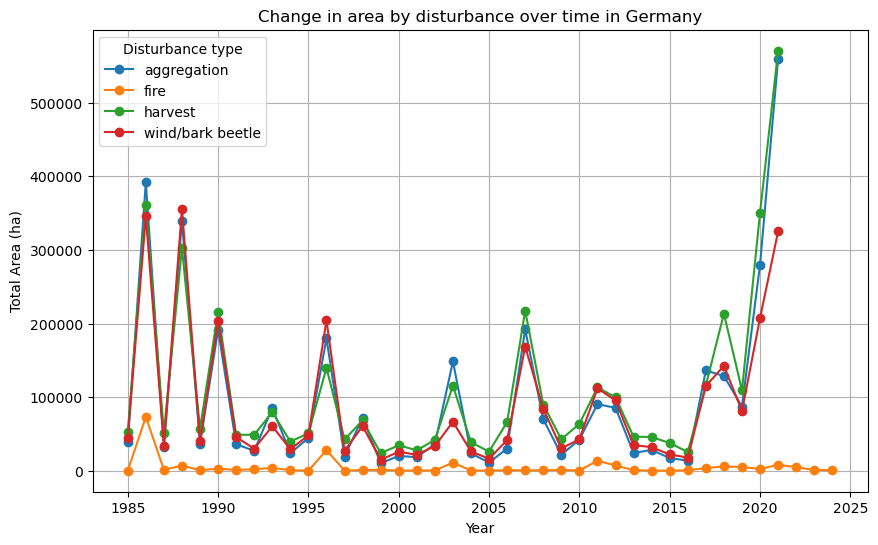

In [ ]:
# line graph
pivot_df.plot(kind='line', marker='o', figsize=(10, 6))
plt.xlabel('Year')
plt.ylabel('Total Area (ha)')
plt.title('Change in area by disturbance over time in Germany')
plt.legend(title='Disturbance type')
plt.grid(True)
plt.savefig("../events/events_over_time", format="pdf", bbox_inches="tight")
plt.show()

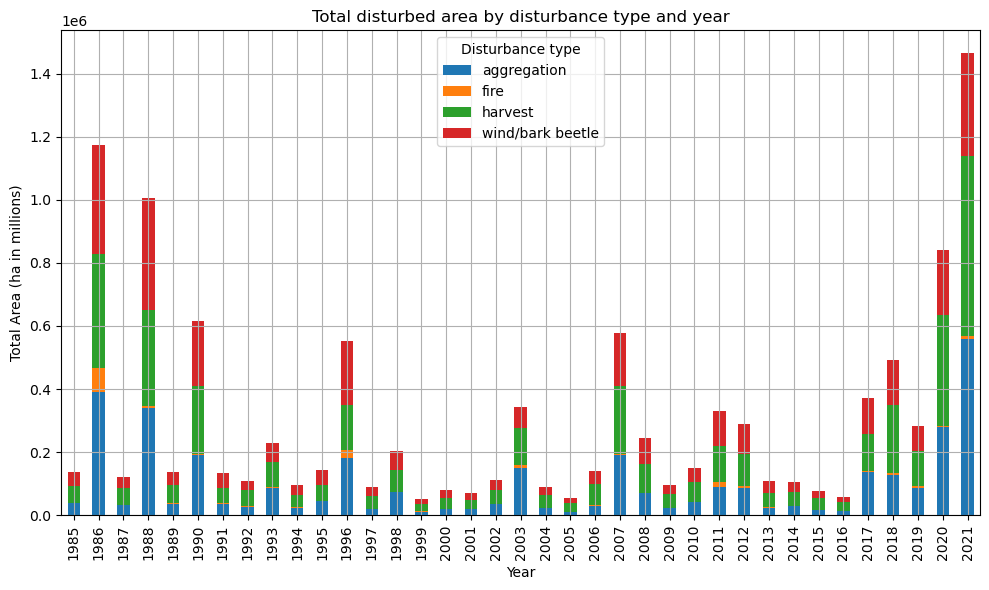

In [69]:
# stacked bar graph
pivot_df.plot(kind='bar', stacked=True, figsize=(10, 6))

plt.xlabel('Year')
plt.ylabel('Total Area (ha in millions)') 
plt.title('Total disturbed area by disturbance type and year')
plt.legend(title='Disturbance type')
plt.grid(True)
plt.tight_layout()
plt.savefig("../events/stacked_bar", format="png", bbox_inches="tight")
plt.show()